# MLP from Scratch - Wine Quality Prediction

Implementing a Multi-Layer Perceptron from scratch using only NumPy, sklearn, Pandas, and Matplotlib.


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo


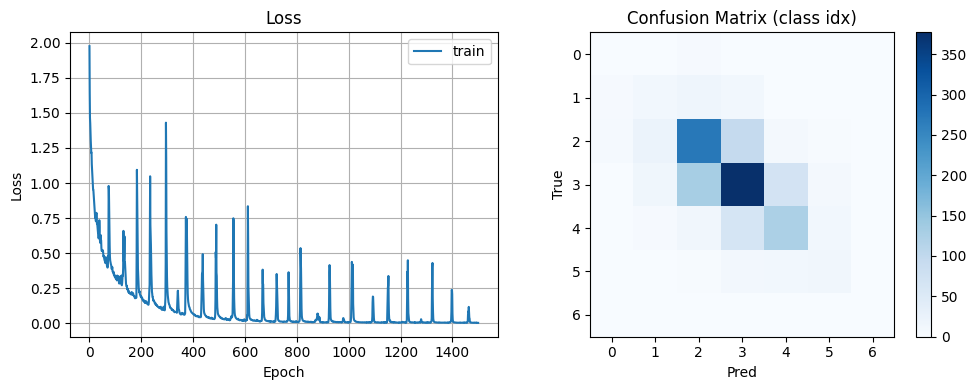

In [2]:
## Data Loading


In [3]:
# (duplicate header removed)

In [4]:
wine_quality = fetch_ucirepo(id=186)

X = wine_quality.data.features
y = wine_quality.data.targets

print(wine_quality.metadata)
print(wine_quality.variables)


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [5]:
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:\n{y.value_counts().sort_index()}")


Features shape: (6497, 11)
Target shape: (6497, 1)

Target distribution:
quality
3            30
4           216
5          2138
6          2836
7          1079
8           193
9             5
Name: count, dtype: int64


## Data Preprocessing


In [ ]:
seed = 42

# Split into train/test first
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)

# Split train into train/val (for val loss + early stopping)
X_tr_df, X_va_df, y_tr_df, y_va_df = train_test_split(
    X_train_df, y_train_df, test_size=0.15, random_state=seed, stratify=y_train_df
)

# Scale using TRAIN split only (avoid leakage)
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr_df)
X_va = scaler.transform(X_va_df)
X_test = scaler.transform(X_test_df)

# Convert targets to 1D numpy
y_tr = np.array(y_tr_df).flatten()
y_va = np.array(y_va_df).flatten()
y_test = np.array(y_test_df).flatten()

# Stable class mapping (quality values)
classes = sorted(np.unique(np.concatenate([y_tr, y_va, y_test])))
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
n_classes = len(classes)

# Integer labels
y_tr_idx = np.array([class_to_idx[v] for v in y_tr])
y_va_idx = np.array([class_to_idx[v] for v in y_va])
y_test_idx = np.array([class_to_idx[v] for v in y_test])

# One-hot encode
y_tr_oh = np.eye(n_classes)[y_tr_idx]
y_va_oh = np.eye(n_classes)[y_va_idx]
y_test_oh = np.eye(n_classes)[y_test_idx]

print(f"Train: {X_tr.shape}, Val: {X_va.shape}, Test: {X_test.shape}")
print(f"Classes: {classes}")



Train: (4417, 11), Val: (780, 11), Test: (1300, 11)
Classes: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


## MLP Implementation from Scratch


In [ ]:
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, class_weights=None, dropout_rate=0.0, optimizer='adam', lr=0.003, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.0, seed=42):
        self.rng = np.random.default_rng(seed)
        self.layers = [input_size] + hidden_sizes + [output_size]
        self.W = []
        self.b = []

        # Optional class weights (we will NOT use them in the default run)
        self.class_weights = None if class_weights is None else class_weights.reshape(1, -1)

        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        self.t = 0

        # He/Xavier-style init
        for i in range(len(self.layers) - 1):
            w = self.rng.standard_normal((self.layers[i], self.layers[i+1])) * np.sqrt(2.0 / self.layers[i])
            b = np.zeros((1, self.layers[i+1]))
            self.W.append(w)
            self.b.append(b)

        # Adam moment estimates
        self.mW = [np.zeros_like(w) for w in self.W]
        self.vW = [np.zeros_like(w) for w in self.W]
        self.mB = [np.zeros_like(b) for b in self.b]
        self.vB = [np.zeros_like(b) for b in self.b]
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X, training=True):
        self.z = []
        self.a = [X]
        self.masks = []
        
        # Forward through hidden layers
        for i in range(len(self.W) - 1):
            z = np.dot(self.a[-1], self.W[i]) + self.b[i]
            self.z.append(z)
            a = self.relu(z)
            if training and self.dropout_rate > 0:
                keep_prob = 1.0 - self.dropout_rate
                mask = self.rng.binomial(1, keep_prob, size=a.shape) / keep_prob
                a = a * mask
                self.masks.append(mask)
            else:
                self.masks.append(None)
            self.a.append(a)
        
        # Output layer with softmax
        z_out = np.dot(self.a[-1], self.W[-1]) + self.b[-1]
        self.z.append(z_out)
        a_out = self.softmax(z_out)
        self.a.append(a_out)
        
        return a_out
    
    def cross_entropy_loss(self, y_pred, y_true):
        # Unweighted CE by default
        if self.class_weights is None:
            return -np.mean(np.sum(y_true * np.log(y_pred + 1e-15), axis=1))

        # Optional weighted CE
        log_probs = -np.log(y_pred + 1e-15)
        sample_weights = (y_true * self.class_weights).sum(axis=1, keepdims=True)
        weighted_loss = np.sum(sample_weights * y_true * log_probs)
        loss = weighted_loss / (sample_weights.sum() + 1e-15)
        return loss

    def backward(self, y_true, output, weight_decay):
        grads_W = [None] * len(self.W)
        grads_b = [None] * len(self.b)

        # Unweighted softmax+CE gradient (default)
        if self.class_weights is None:
            denom = y_true.shape[0]
            dz = (output - y_true)
            grads_W[-1] = np.dot(self.a[-2].T, dz) / denom + weight_decay * self.W[-1]
            grads_b[-1] = np.sum(dz, axis=0, keepdims=True) / denom
        else:
            sample_weights = (y_true * self.class_weights).sum(axis=1, keepdims=True)
            denom = sample_weights.sum() + 1e-15
            dz = (output - y_true) * sample_weights
            grads_W[-1] = np.dot(self.a[-2].T, dz) / denom + weight_decay * self.W[-1]
            grads_b[-1] = np.sum(dz, axis=0, keepdims=True) / denom

        # Backpropagate through hidden layers
        da = np.dot(dz, self.W[-1].T)
        for i in range(len(self.W) - 2, -1, -1):
            if self.masks[i] is not None:
                da = da * self.masks[i]
            dz = da * self.relu_derivative(self.z[i])
            grads_W[i] = np.dot(self.a[i].T, dz) / denom + weight_decay * self.W[i]
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / denom
            if i > 0:
                da = np.dot(dz, self.W[i].T)
        return grads_W, grads_b
    
    def apply_gradients(self, grads_W, grads_b, lr):
        if self.optimizer == 'adam':
            self.t += 1
            for i in range(len(self.W)):
                self.mW[i] = self.beta1 * self.mW[i] + (1 - self.beta1) * grads_W[i]
                self.vW[i] = self.beta2 * self.vW[i] + (1 - self.beta2) * (grads_W[i] ** 2)
                self.mB[i] = self.beta1 * self.mB[i] + (1 - self.beta1) * grads_b[i]
                self.vB[i] = self.beta2 * self.vB[i] + (1 - self.beta2) * (grads_b[i] ** 2)
                mW_hat = self.mW[i] / (1 - self.beta1 ** self.t)
                vW_hat = self.vW[i] / (1 - self.beta2 ** self.t)
                mB_hat = self.mB[i] / (1 - self.beta1 ** self.t)
                vB_hat = self.vB[i] / (1 - self.beta2 ** self.t)
                self.W[i] -= lr * mW_hat / (np.sqrt(vW_hat) + self.eps)
                self.b[i] -= lr * mB_hat / (np.sqrt(vB_hat) + self.eps)
        else:  # vanilla SGD
            for i in range(len(self.W)):
                self.W[i] -= lr * grads_W[i]
                self.b[i] -= lr * grads_b[i]
    
    def train(self, X, y, X_val=None, y_val=None, y_val_idx=None,
              epochs=1000, lr=None, decay_rate=0.9995, batch_size=128, weight_decay=0.0,
              patience=20, seed=42, print_every=100, label_smoothing=0.0):
        if lr is None:
            lr = self.lr

        tr_loss = []
        va_loss = []
        va_w1 = []

        # best checkpoint chosen by (val_within1, -val_loss)
        best_key = (-1.0, -np.inf)
        best_state = None
        bad = 0

        n = X.shape[0]
        rng = np.random.default_rng(seed)

        for epoch in range(epochs):
            # Deterministic shuffle
            perm = rng.permutation(n)
            X_shuf = X[perm]
            y_shuf = y[perm]

            current_lr = lr * (decay_rate ** epoch)

            epoch_loss_sum = 0.0
            for start in range(0, n, batch_size):
                end = start + batch_size
                xb = X_shuf[start:end]
                yb = y_shuf[start:end]

                out = self.forward(xb, training=True)

                # label smoothing (training only)
                if label_smoothing and label_smoothing > 0:
                    k = yb.shape[1]
                    yb_used = (1.0 - label_smoothing) * yb + (label_smoothing / k)
                else:
                    yb_used = yb

                loss_b = self.cross_entropy_loss(out, yb_used)
                grads_W, grads_b = self.backward(yb_used, out, weight_decay)
                self.apply_gradients(grads_W, grads_b, current_lr)
                epoch_loss_sum += float(loss_b) * len(xb)

            l_tr = epoch_loss_sum / n
            tr_loss.append(l_tr)

            if X_val is not None and y_val is not None:
                out_va = self.forward(X_val, training=False)
                l_va = float(self.cross_entropy_loss(out_va, y_val))
                va_loss.append(l_va)

                # validation within-1 (works on class index because qualities are consecutive)
                if y_val_idx is not None:
                    pred_va_idx = np.argmax(out_va, axis=1)
                    w1 = float(np.mean(np.abs(pred_va_idx - y_val_idx) <= 1))
                else:
                    w1 = float('nan')
                va_w1.append(w1)

                # choose best by (val_within1, -val_loss)
                key = (w1, -l_va)
                if (key[0] > best_key[0] + 1e-6) or (abs(key[0] - best_key[0]) <= 1e-6 and key[1] > best_key[1] + 1e-6):
                    best_key = key
                    best_state = ([w.copy() for w in self.W], [b.copy() for b in self.b])
                    bad = 0
                else:
                    bad += 1

                if bad >= patience:
                    if best_state is not None:
                        self.W, self.b = best_state
                    break

            if (epoch + 1) % print_every == 0:
                if len(va_loss) > 0:
                    vw1 = va_w1[-1]
                    print(f"Epoch {epoch+1}/{epochs} | loss={l_tr:.4f} | val_loss={va_loss[-1]:.4f} | val_w1={vw1:.4f} | lr={current_lr:.6f}")
                else:
                    print(f"Epoch {epoch+1}/{epochs} | loss={l_tr:.4f} | lr={current_lr:.6f}")

        return tr_loss, va_loss, va_w1
    
    def predict(self, X):
        output = self.forward(X, training=False)
        return np.argmax(output, axis=1)



## Model Training


In [ ]:
input_size = X_tr.shape[1]
hidden_sizes = [128, 64, 32]
output_size = n_classes

# Final chosen config (from ablation)
cfg = {"dropout": 0.10, "wd": 3e-4, "ls": 0.05}

def test_metrics(m):
    yp = m.predict(X_test)
    yt = y_test_idx
    acc_exact = accuracy_score(yt, yp)
    acc_w1 = float(np.mean(np.abs(yp - yt) <= 1))
    return acc_exact, acc_w1

mlp = MLP(
    input_size,
    hidden_sizes,
    output_size,
    class_weights=None,
    dropout_rate=cfg["dropout"],
    optimizer='adam',
    lr=0.003,
    weight_decay=0.0,
    seed=seed,
)

tr_loss, va_loss, va_w1 = mlp.train(
    X_tr,
    y_tr_oh,
    X_val=X_va,
    y_val=y_va_oh,
    y_val_idx=y_va_idx,
    epochs=1500,
    batch_size=128,
    lr=0.003,
    decay_rate=0.9995,
    weight_decay=cfg["wd"],
    patience=25,
    seed=seed,
    print_every=200,
    label_smoothing=cfg["ls"],
)



## Model Evaluation


In [9]:
y_pred_idx = mlp.predict(X_test)
y_true_idx = y_test_idx

# exact accuracy on class indices
acc_exact = accuracy_score(y_true_idx, y_pred_idx)

# within-1 accuracy on actual quality values
pred_q = np.array([idx_to_class[i] for i in y_pred_idx])
true_q = np.array([idx_to_class[i] for i in y_true_idx])
acc_w1 = np.mean(np.abs(pred_q - true_q) <= 1)

print(f"Exact Accuracy: {acc_exact:.4f}")
print(f"Within-1 Accuracy: {acc_w1:.4f}")

print("\nClassification Report (by class index):")
print(classification_report(y_true_idx, y_pred_idx))



Exact Accuracy: 0.5731
Within-1 Accuracy: 0.9623

Classification Report (by class index):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00        43
           2       0.62      0.61      0.62       428
           3       0.55      0.72      0.62       567
           4       0.54      0.35      0.43       216
           5       0.00      0.00      0.00        39
           6       0.00      0.00      0.00         1

    accuracy                           0.57      1300
   macro avg       0.24      0.24      0.24      1300
weighted avg       0.54      0.57      0.55      1300



/Users/sooryas/Code/Cryptonite task phase/task phase 3/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sooryas/Code/Cryptonite task phase/task phase 3/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sooryas/Code/Cryptonite task phase/task phase 3/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

## Visualizations


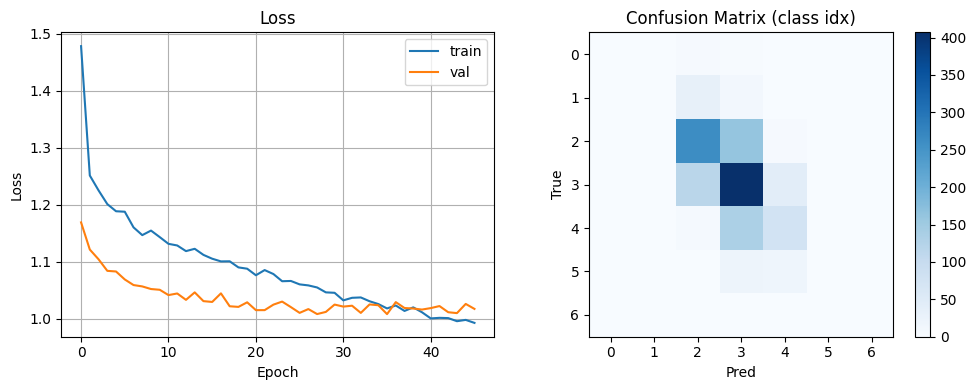

In [10]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(tr_loss, label='train')
if len(va_loss) > 0:
    plt.plot(va_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_true_idx, y_pred_idx)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (class idx)')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Pred')
plt.tight_layout()
plt.show()


In [11]:
## Results Analysis


In [12]:
print("Model Performance Summary:")
print(f"- Final Train Loss: {tr_loss[-1]:.4f}")
if len(va_loss) > 0:
    print(f"- Final Val Loss: {va_loss[-1]:.4f}")
print(f"- Exact Accuracy: {acc_exact:.4f}")
print(f"- Within-1 Accuracy: {acc_w1:.4f}")
print(f"- Architecture: {input_size} -> {' -> '.join(map(str, hidden_sizes))} -> {output_size}")


Model Performance Summary:
- Final Train Loss: 0.9930
- Final Val Loss: 1.0176
- Exact Accuracy: 0.5731
- Within-1 Accuracy: 0.9623
- Architecture: 11 -> 128 -> 64 -> 32 -> 7


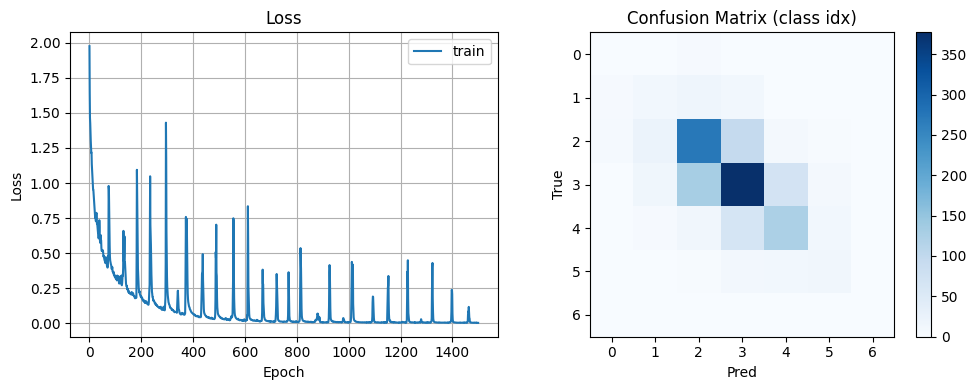

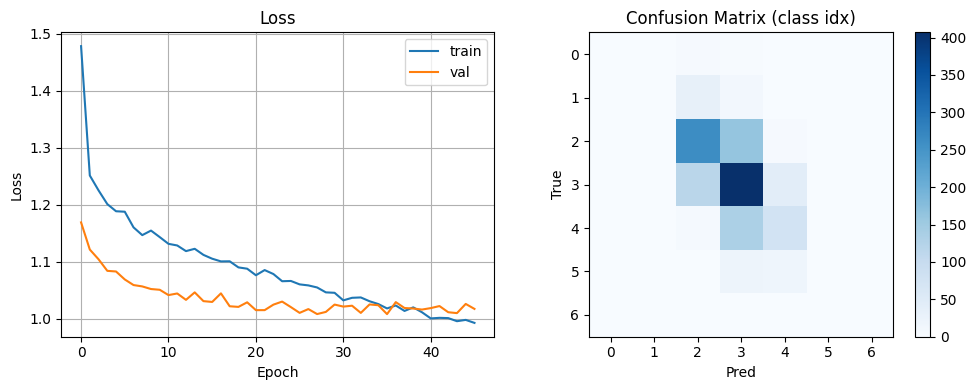

In [13]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(tr_loss, label='train')
if len(va_loss) > 0:
    plt.plot(va_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_true_idx, y_pred_idx)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (class idx)')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Pred')
plt.tight_layout()
plt.show()


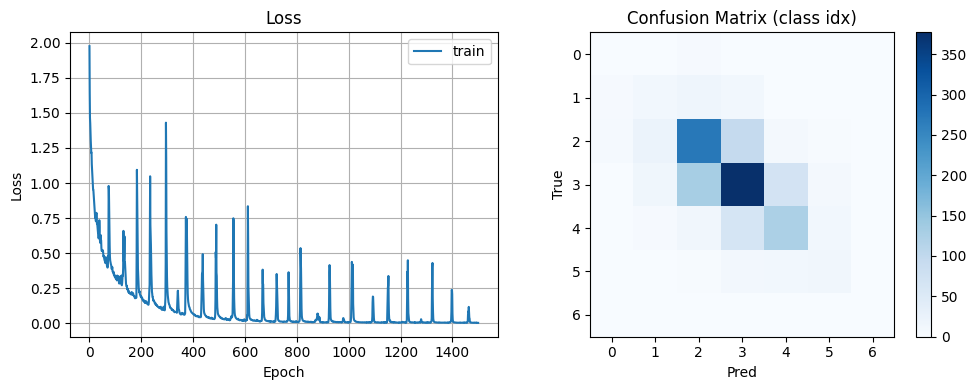